# Multi-Task Segmentation Models
Click to open in: [[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/09-multi-task-segmentation.ipynb)][[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/09-multi-task-segmentation.ipynb)]

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo
In image processing it may be desirable to perform multiple tasks simultaneously with the same model. This may not only have the advantage of decreasing processing time (in comparison to doing both tasks separately), but it may also provide complementary information to improve the accuracy of each task. Thus, some multi-task models may actually provide better results when compared to separate models performing the tasks independently. For example, within histology, certain nucleus types may be more prominent in specific tissue regions - e.g. epithelial cells within the epithelium vs. inflammatory cells within the connective tissue. Thus, a model which learns to semantically segment tissue regions in addition to segmenting/classifying nuclear instances may actually provide superior results when compared to individual models.

In this notebook, we demonstrate how to use [HoVer-Net+](https://arxiv.org/pdf/2108.13904.pdf), a subclass of [HoVer-Net](https://arxiv.org/pdf/1812.06499.pdf), for the semantic segmentation of intra-epithelial layers, whilst simultaneously segmenting/classifying nuclear instances (epithelial, inflammatory etc.). This model has been trained on a private cohort of oral epithelial dysplasia cases (not publicly available). For more information on these individual tasks (e.g. semantic segmentation and nuclear instance segmentation) please see their respective example notebooks. We will first show how this pretrained model, incorporated in TIAToolbox, can be used for multi-task inference on large image patches, before explaining how to use your pretrained model in the TIAToolbox model inference pipeline to do prediction on a set of WSIs.

## Setting up the environment
### TIAToolbox and dependencies installation
You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1

print("Installation is done.")

> **IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *"Runtime&#8594;Restart runtime"* . This is needed to load the latest versions of prerequisite packages installed with TIAToolbox. Doing so, you should be able to run all the remaining cells altogether (*"Runtime&#8594;Run after"* from the next cell) or one by one.

### GPU or CPU runtime
Processes in this notebook can be accelerated by using a GPU. Therefore, whether you are running this notebook on your system or Colab, you need to check and specify if you are using GPU or CPU hardware acceleration. In Colab, you need to make sure that the runtime type is set to GPU in the *"Runtime&#8594;Change runtime type&#8594;Hardware accelerator"*. If you are *not* using GPU, consider changing the `ON_GPU` flag to `Flase` value, otherwise, some errors will be raised when running the following cells.

In [ ]:
ON_GPU = True  # Should be changed to False if no cuda-enabled GPU is available

### Removing leftovers from previous runs
The cell below removes some redundant directories if they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.

In [ ]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d sample_tile_results ] && !( echo "deleting 'sample_tile_results' directory"; rm -r sample_tile_results)
![ -d sample_wsi_results ] && ( echo "deleting 'sample_wsi_results' directory"; rm -r sample_wsi_results)
import warnings

warnings.filterwarnings("ignore")

### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [1]:
from tiatoolbox.models.engine.semantic_segmentor import SemanticSegmentor
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import WSIReader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how semantic segmentation models work. Pretrained weights of a Pytorch model and a small WSI are downloaded to illustrate how to incorporate your own models in the existing TIAToolbox segmentation tool.
>In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see a list of files that have been downloaded and are thus directly accessible from this notebook.
>
> 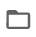

In [3]:
from tiatoolbox.utils.misc import download_data

# These file name are used for
img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"

print("Download has started. Please wait...")

# Downloading sample image tile
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/tcga_hnscc.png", img_file_name
)

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/testdata/models/samples/wsi2_4k_4k.svs",
    wsi_file_name,
)

print("Download is complete.")

Download has started. Please wait...
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/tcga_hnscc.png
Save to sample_tile.png
Download from https://tiatoolbox.dcs.warwick.ac.uk/testdata/models/samples/wsi2_4k_4k.svs
Save to sample_wsi.svs
Download is complete.


## Multi-Task Segmentation using TIAToolbox pretrained models
In this section, we investigate the use of multi-task models that have been already trained on specific tasks and incorporated in the TIAToolbox. We will particularly focus on [HoVer-Net+](https://arxiv.org/pdf/2108.13904.pdf), however, in the future we plan to incorporate more models. HoVer-Net+ has an encoder-decoder framework, consisting of multiple decoder branches that allows it to perform multiple tasks simultaneouly. It is therefore assumed that the representation of the input image learned by the encoder, is useful for both donwstream tasks. This model performs two tasks:

1) It segments out nuclear instances from the given input, whilst assigning them to one of two classes: epithelial nuclei or other nuclei (connective/immune cell etc.).

2) The model semantically segments tissue regions, classifying each indiviudal pixel of a image tile or WSI, as one of five tissue types:

> - (Superficial) keratin layer
> - Epithelial layer
> - Basal epithelial layer
> - Other (connective tissue etc.)
> - Background

Note, the first three tissue classes can be considered as the three layers of the epithelium.

> More information on the model and the dataset used for training can be found [here](https://arxiv.org/pdf/2108.13904.pdf) (_Shephard et al., "Simultaneous Nuclear Instance and Layer Segmentation in Oral Epithelial Dysplasia"_) and the data is available for download using this [link](https://github.com/PathologyDataScience/BCSS).

### Inference on tiles
Similarly to the semantic segmentation functionality of the tiatoolbox, the multi-task segmentation module works on both image tiles and structured WSIs. First, we need to create an instance of the `SemanticSegmentor` class which controls the whole process of multi-task segmentation and then use it to do prediction on the input image(s):

In [4]:
# Tile prediction
multi_segmentor = SemanticSegmentor(
    pretrained_model="hovernetplus-oed",
    num_loader_workers=2,
    num_postproc_workers=2,
    batch_size=4,
)

tile_output = multi_segmentor.predict(
    [img_file_name],
    save_dir="sample_tile_results/",
    mode="tile",
    on_gpu=ON_GPU,
    crash_on_exception=True,
)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/hovernetplus-oed.pth
Save to /home/adams/.tiatoolbox/models/hovernetplus-oed.pth


|2021-12-22|10:00:37.983| [WARNING] /home/adams/Projects/TIAToolbox/tiatoolbox/tiatoolbox/models/engine/semantic_segmentor.py:1026: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "

|2021-12-22|10:00:39.572| [WARNING] /home/adams/Projects/TIAToolbox/tiatoolbox/tiatoolbox/models/engine/semantic_segmentor.py:275: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  "WSIPatchDataset only reads image tile at "

|2021-12-22|10:00:39.700| [WARNING] /home/adams/Projects/TIAToolbox/tiatoolbox/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2021-12-22|10:00:39.701| [WARNING] /home/adams/Projects/TIAToolbox/tiatoolbox/tiatoolbox/wsicore/wsimeta.py:174: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_po

There we go! With only two lines of code, thousands of images can be processed automatically.
There are many parameters associated with `SemanticSegmentor`. Please see the `SemanticSegmentor` [notebook](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/06-semantic-segmentation.ipynb) and [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture) for more information on these parameters. Here we explain only the ones mentioned above:

- `pretrain_model`: specifies the name of the pretrained model included in the TIAToolbox (case sensitive). We are expanding our library of models pretrained on various segmentation tasks. You can find a complete list of available pretrained models [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture). In this example, we use the `"hovernetplus-oed"` pretrained model, which is the [HoVer-Net+ model](https://arxiv.org/pdf/2108.13904.pdf) trained on a private cohort of oral epithelial dysplasia cases.

- `num_loader_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "loading of network input" process, which consists of patch extraction, preprocessing, etc.

- `batch_size`: controls the batch size, or the number of input instances to the network in each iteration. If you use a GPU, be careful not to set the `batch_size` larger than the GPU memory limit would allow.

After the `multi_segmentor` has been instantiated as a semantic segmentation engine with our desired pretrained model, one can call the `predict` method to do inference on a list of input images (or WSIs). The `predict` function automatically processes all the images on the input list and saves the results on the disk. The process usually comprises patch extraction (because the whole tile or WSI won't fit into limited GPU memory), preprocessing, model inference, post-processing and prediction assembly. Here are some important parameters that should be set to use the `predict` method properly:

- `imgs`: List of inputs to be processed. Note that items in the list should be paths to the inputs stored on the disk.

- `save_dir`: Path to the main folder in which prediction results for each input will be stored separately.

- `mode`: the mode of inference which can be set to either `'tile'` or `'wsi'`, for plain histology images or structured whole slides images, respectively.

- `on_gpu`: can be either `True` or `False` to dictate running the computations on GPU or CPU.

- `crash_on_exception`: If set to `True`, the running loop will crash if there is an error during processing a WSI. Otherwise, the loop will move on to the next image (wsi) for processing. We suggest that you first make sure that prediction is working as expected by testing it on a couple of inputs and then set this flag to `False` to process large cohorts of inputs.

In the `output`, the `prediction` method returns a list of the paths to its inputs and to the processed outputs saved on the disk. This can be used for loading the results for processing and visualisation.

Now that the prediction has finished, let's use the paths in `tile_output` to load and examine the predictions.

prediction method output is: [['sample_tile.png', '/home/adams/Projects/TIAToolbox/tiatoolbox/examples/sample_tile_results/0']]
Processed prediction dimensions: (2000, 2000)
Input image dimensions: (2000, 2000, 3)


|2021-12-22|10:01:10.795| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


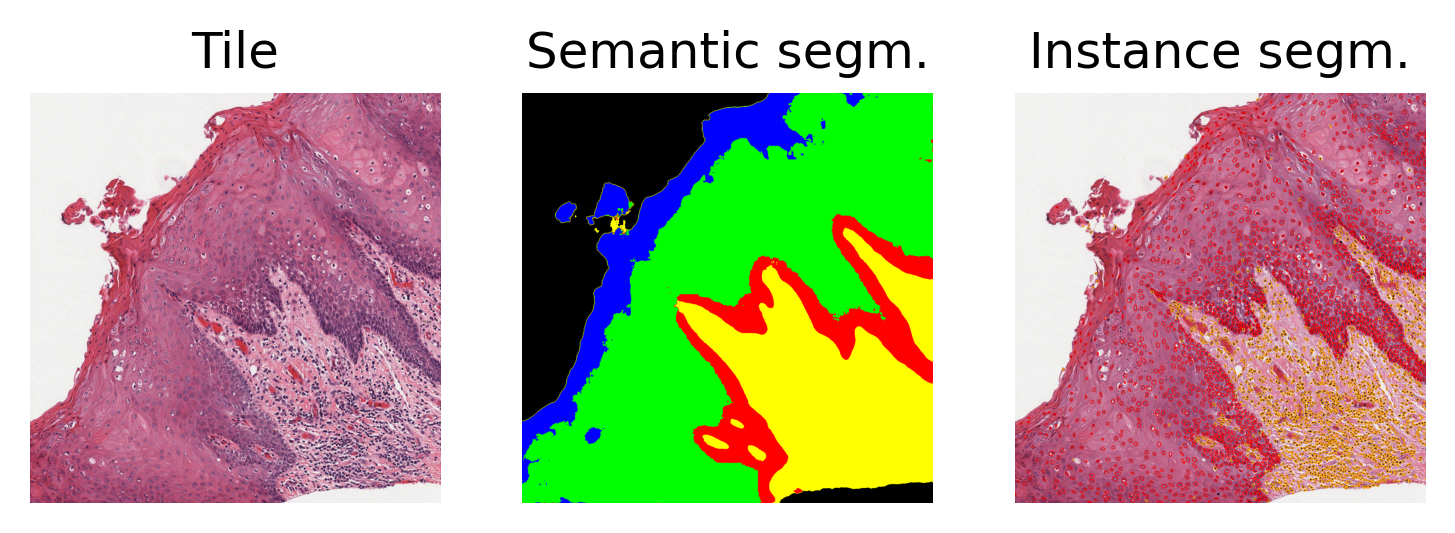

In [5]:
# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import overlay_prediction_contours

print("prediction method output is: {}".format(tile_output))
# Loading the first prediction [0] based on the output address [1] for all four decoders
# Note, there are four outputs here - hence the range(4) - these correspond to the outputs from
# each of the four decoders of HoVer-Net+
raw_maps = [np.load(f"{tile_output[0][1]}.raw.{head_idx}.npy") for head_idx in range(4)]

# Post-processing HoVer-Net+'s 4 outputs to produce a layer segmentation and nuclear instance map
inst_map, inst_dict, layer_map, layer_dict = multi_segmentor.model.postproc(raw_maps)

print("Processed prediction dimensions: {}".format(inst_map.shape))

# showing the predicted semantic segmentation
tile = imread(img_file_name)
print("Input image dimensions: {}".format(tile.shape))

semantic_color_dict = {
    0: ("Background", (0, 0, 0)),
    1: ("Other", (255, 165, 0)),
    2: ("Basal", (255, 0, 0)),
    3: ("Epithelial", (0, 255, 0)),
    4: ("Keratin", (0, 0, 255)),
}

inst_color_dict = {
    0: ("Background", (0, 0, 0)),
    1: ("Other", (255, 165, 0)),
    2: ("Epithelium", (255, 0, 0)),
}

# Create the overlay image
overlaid_predictions_inst = overlay_prediction_contours(
    canvas=tile,
    inst_dict=inst_dict,
    draw_dot=False,
    type_colours=inst_color_dict,
    line_thickness=2,
)

# Create the semantic segmentation image (in colour)
semantic_map = np.zeros((layer_map.shape[0], layer_map.shape[1], 3))
for idx, (label, color) in semantic_color_dict.items():
    semantic_map[layer_map == idx] = color

# showing processed results alongside the original images
fig2 = plt.figure()
ax1 = plt.subplot(1, 3, 1), plt.imshow(tile), plt.axis("off"), plt.title("Tile")
ax2 = (
    plt.subplot(1, 3, 2),
    plt.imshow(semantic_map),
    plt.axis("off"),
    plt.title("Semantic segm."),
)
ax3 = (
    plt.subplot(1, 3, 3),
    plt.imshow(overlaid_predictions_inst),
    plt.axis("off"),
    plt.title("Instance segm."),
)

Above, we display the raw image tile, along with the semantic segmentation and nuclear instance segmentation predictions. In the instance prediction map, the contours of the nuclear instances are drawn. Red contours represent epithelial nuclei, whilst orange contours represent other nuclei. In the semantic segmentation prediction map, blue represents the keratin layer, green the epithelial layer, red the basal epithelial layer, orange is other tissue, and finally black is background. As can be seen in the commented code above, the raw prediction consists of four outputs. These outputs are from each of the four decoders used in HoVer-Net+:

1) Nuclear pixel branch: This branch segments nuclei from background

2) Nuclear classification branch: This branch assigns a class to each predicted nuclei

3) HoVer branch: This branch estimates the horizontal and vertical distances of each pixel in a nucleus from it's centre of mass. In doing so this branch helps to differentiate between touching/overlapping nuclear instances.

4) Layer segmentaion branch: This branch is for semantic segmentation of tissue regions.

The first three branches relate to instance segmentation, where the outputs are combined in post-processing to generate nuclear instance segmentations/classification. The fourth branch alone is then used to segment different tissue regions. See the [HoVer-Net+](https://arxiv.org/pdf/2108.13904.pdf) paper for an in-depth description of these branches and their outputs. We load each of these outputs and simply use HoVer-Net+'s post-processing function to transform these into instance segmentation and semantic segmentation maps. These prediction channels are illustrated in the first row above, one-by-one, where each prediction map stands for a specific tissue region class. We additionally wish to perform some post-processing to ensure sensible outputs. Therefore, we use a very simple post-processing technique to acquire the semantic segmentation and the nuclear instance maps:
> `inst_map, inst_dict, layer_map, layer_dict = multi_segmentor.model.postproc(raw_maps)`

This method generates dictionaries (`inst_info_dict` and `layer_info_dict`) listing the regions segmented by the semantic segmentation part of the network and the nuclear instances segmented by the nuclear instance part.

### Inference on WSIs
The next step is to use TIAToolbox's embedded model for region segmentation in a whole slide image. The process is quite similar to what we have done for tiles. Here we introduce some important parameters that should be considered when configuring the segmentor for WSI inference. For this example we infer HoVer-Net+ on a small breast tissue WSI.

In [6]:
multi_segmentor = SemanticSegmentor(
    pretrained_model="hovernetplus-oed",
    num_loader_workers=4,
    batch_size=4,
    auto_generate_mask=False,
)

# WSI prediction
wsi_output = multi_segmentor.predict(
    imgs=[wsi_file_name],
    masks=None,
    save_dir="sample_wsi_results/",
    mode="wsi",
    on_gpu=ON_GPU,
    crash_on_exception=True,
)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/hovernetplus-oed.pth
Save to /home/adams/.tiatoolbox/models/hovernetplus-oed.pth


Process Batch: 100%|############################| 43/43 [00:14<00:00,  2.97it/s]
|2021-12-22|10:01:34.239| [INFO] Finish: 0/1
|2021-12-22|10:01:34.240| [INFO] --Input: sample_wsi.svs
|2021-12-22|10:01:34.241| [INFO] --Ouput: /home/adams/Projects/TIAToolbox/tiatoolbox/examples/sample_wsi_results/0


Note the only differences made here are:
1. Adding `auto_generate_mask=False` to the `SemanticSegmentor`. If `True` and if no `masks` input is provided to the `predict` function, the toolbox automatically extracts tissue masks from WSIs.
2. Setting `mode='wsi'` in the `predict` function indicates that we are predicting region segmentations for inputs in the form of WSIs.
3. `masks=None` in the `predict` function: the `masks` argument is a list of paths to the desired image masks. Patches from `imgs` are only processed if they are within a masked area of their corresponding `masks`. If not provided (`masks=None`), then either a tissue mask is automatically generated for whole-slide images or the entire image is processed as a collection of image tiles.

The above cell might take a while to process, especially if you have set `ON_GPU=False`. The processing time depends on the size of the input WSI and the selected resolution. Here, we have not specified any values and we use the assumed input resolution (20x) of HoVer-Net+.

prediction method output is: [['sample_wsi.svs', '/home/adams/Projects/TIAToolbox/tiatoolbox/examples/sample_wsi_results/0']]
Processed prediction dimensions: (2016, 2016)
WSI original dimensions: (4000, 4000)
WSI overview dimensions: (2016, 2016, 3)


Text(0.5, 1.0, 'Semantic Segmentation Overlaid')

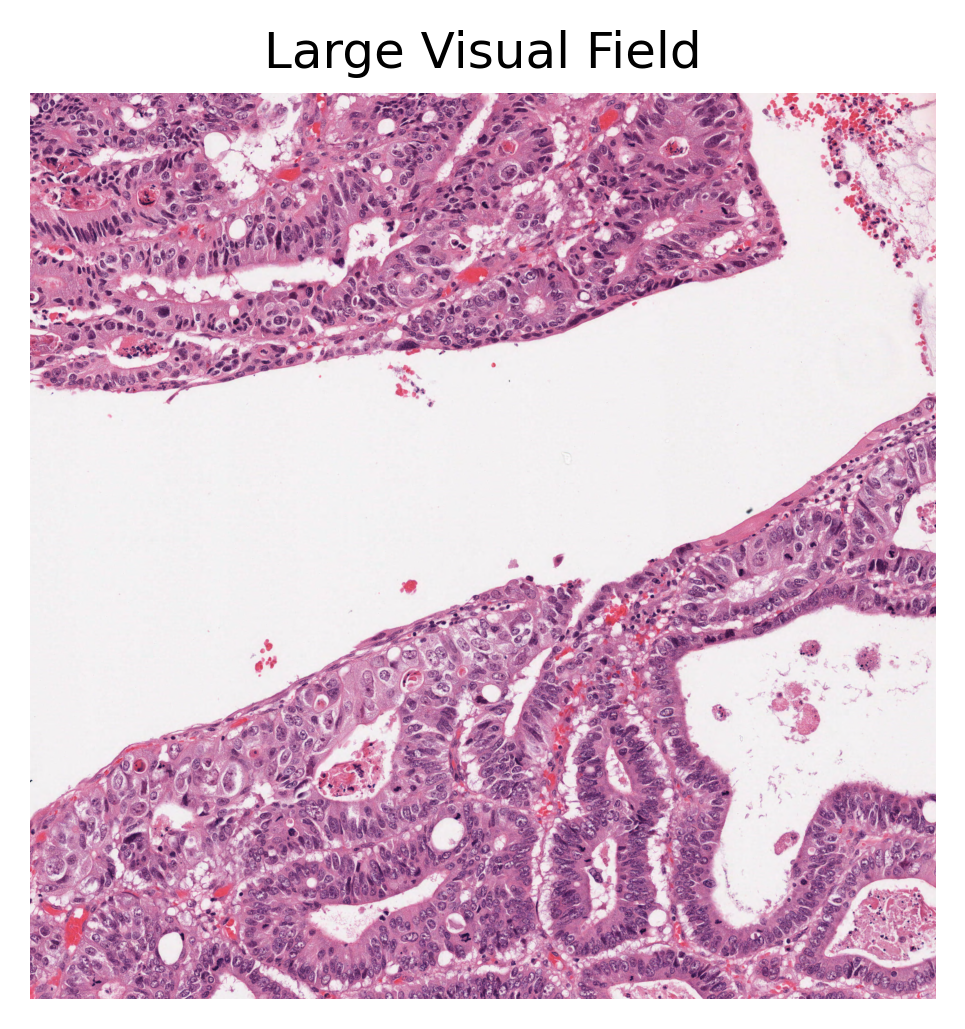

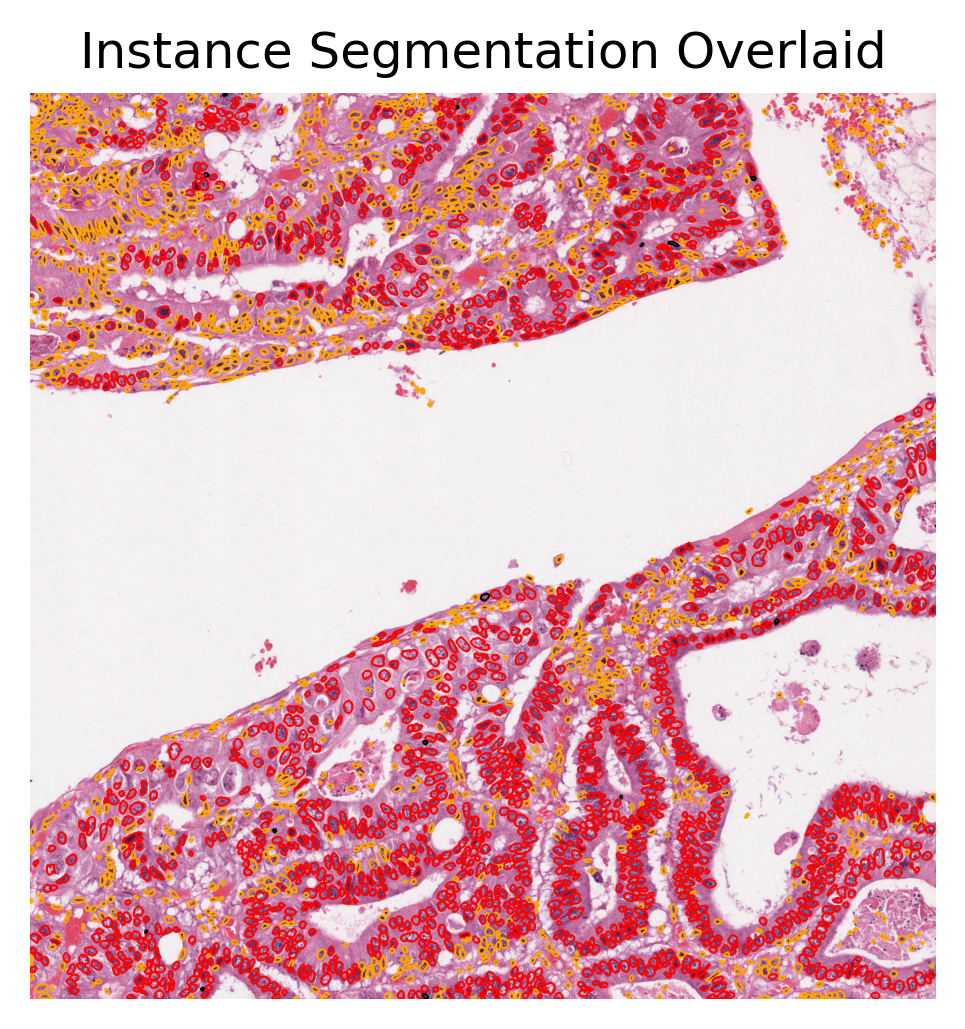

<Figure size 1800x1200 with 0 Axes>

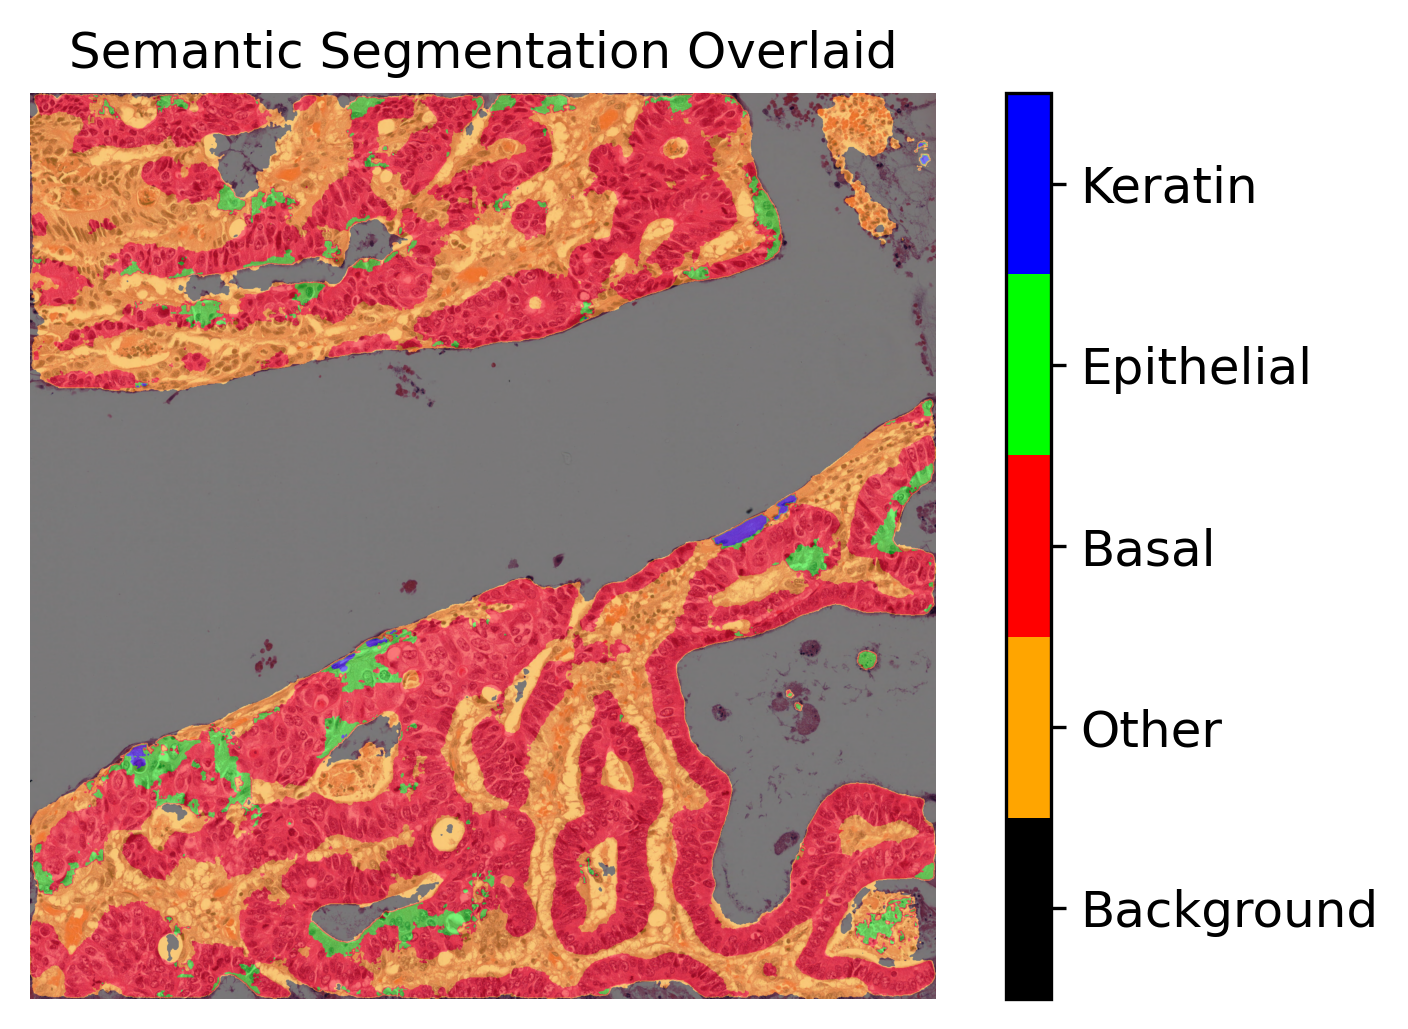

In [8]:
from tiatoolbox.utils.visualization import overlay_prediction_mask

print("prediction method output is: {}".format(wsi_output))
raw_maps = [np.load(f"{wsi_output[0][1]}.raw.{head_idx}.npy") for head_idx in range(4)]

# [Post-processing]
# Post-processing HoVer-Net+'s 4 outputs to produce a layer segmentation and nuclear instance map
inst_map, inst_dict, layer_map, layer_dict = multi_segmentor.model.postproc(raw_maps)
print("Processed prediction dimensions: {}".format(inst_map.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = WSIReader.open(wsi_file_name)
print("WSI original dimensions: {}".format(wsi.info.slide_dimensions))

# Reading the whole slide in the highest resolution as a plane image
wsi_overview = wsi.slide_thumbnail(resolution=0.5, units="mpp")
print("WSI overview dimensions: {}".format(wsi_overview.shape))

semantic_color_dict = {
    0: ("Background", (0, 0, 0)),
    1: ("Other", (255, 165, 0)),
    2: ("Basal", (255, 0, 0)),
    3: ("Epithelial", (0, 255, 0)),
    4: ("Keratin", (0, 0, 255)),
}

inst_color_dict = {
    0: ("Background", (0, 0, 0)),
    1: ("Other", (255, 165, 0)),
    2: ("Epithelium", (255, 0, 0)),
}

# Create the instance segmentation overlay map using the `overlay_prediction_contours` helper function
overlaid_inst_pred = overlay_prediction_contours(
    canvas=wsi_overview,
    inst_dict=inst_dict,
    draw_dot=False,
    type_colours=inst_color_dict,
    line_thickness=4,
)


fig = (
    plt.figure(),
    plt.imshow(wsi_overview),
    plt.axis("off"),
    plt.title("Large Visual Field"),
)
fig = (
    plt.figure(),
    plt.imshow(overlaid_inst_pred),
    plt.axis("off"),
    plt.title("Instance Segmentation Overlaid"),
)
# Create semantic segmentation overlay map using the `overlay_patch_prediction` helper function
fig = plt.figure()
overlaid_semantic_pred = overlay_prediction_mask(
    wsi_overview, layer_map, alpha=0.5, label_info=semantic_color_dict
)
plt.title("Semantic Segmentation Overlaid")

As you can see above, we first post-process the prediction map, in the same way that we did for tiles, to create the semantic and instance segmentation maps (and corresponding dictionaries). Then, in order to visualise the segmentation prediction on the tissue image, we read the processed WSI and extract its overview. Please note that HoVer-Net+ assumes a base resolution of 0.50 mpp, whilst the baseline resolution of the input WSI was 0.252 mpp. Thus, the output of HoVer-Net+ has shape `2016 x 2016`, compared to the input `4000 x 4000`. The overview image is therefore also extracted at this resolution. We did not edit this into the processing of the tile as the tile processing assumes the correct input resolution at baseline. We used the `overlay_prediction_mask` helper function of the TIAToolbox to overlay the predicted semantic segmentation map on the overview image and depict it with a colour legend. We also used the `overlay_prediction_contours` helper function of the TIAToolbox to overlay the predicted instance segmentation map on the overview image.

In the instance prediction map, the contours of the nuclear instances are drawn. Red contours represent epithelial nuclei, whilst orange contours represent other nuclei. In the semantic segmentation prediction map, blue represents the keratin layer, green the epithelial layer, red the basal epithelial layer, orange is other tissue, and finally black is background. Please note that the semantic segmentation output seen above is relatively spurious in areas as a result of the model being trained on head and neck tissue only (specifically within oral epithelial dysplasia). However, the WSI inferred on is from breast tissue and thus the model does not generalise well to this task. We have chosen to include this WSI, despite the results not being perfect, for demonstration purposes.

In summary, it is very easy to use pretrained models in the TIAToolbox to do predefined tasks. In fact, you don't even need to set any parameters related to a model’s input/output when you decide to work with one of TIAToolbox’s pretrained models (they will be set automatically, based on their optimal values).

Feel free to play around with the parameters, models, and experiment with new images (just remember to run the first cell of this notebook again, so that the created folders for the current examples are removed. Alternatively, change the `save_dir` parameters in new calls of `predict` function). Currently, we are extending our collection of pre-trained models. To keep track of them, make sure to follow our releases. You can also check [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture). Furthermore, if you want to use your own pretrained model for semantic segmentation (or any other pixel-wise prediction models) in the TIAToolbox framework, you can follow the instructions in our example notebook on [advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/07_example_modeltechniques.ipynb) to gain some insights and guidance.
We welcome any trained model in computational pathology (in any task) for addition to TIAToolbox. If you have such a model (in Pytorch) and want to contribute, please contact us or simply create a PR on our Github page.
